In [33]:
import os
import torch
import pickle
from transformers import BertTokenizer, BertModel, CamembertModel, CamembertTokenizer, AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Avec CamemBERT (pas au point)

In [166]:
def get_document_embeddings(texts, model, tokenizer):
    vectors = []
    for i, text in enumerate(texts):
        print(f"\r{i} / {len(texts)}, TXT : {text[:20]}", end="")
        input_ids = tokenizer(text, return_tensors="pt", truncation = True, padding = True)
        with torch.no_grad():
            outputs = model(**input_ids)
        vectors.append(outputs.last_hidden_state.mean(dim = 1))
    return(torch.cat(vectors, dim=0))

def semantic_search(query, model, tokenizer, document_embeddings, n_results=5):
    query_embedding = get_document_embeddings(query, model, tokenizer)
    similarity_scores = cosine_similarity(query_embedding, document_embeddings)[0]
    return(similarity_scores)
    # sorted_indices = similarity_scores.argsort()
    # return(sorted_indices[::-1][:n_results])

def save_embeddings(embeddings, output_file):
    with open(output_file, 'wb') as f:
        pickle.dump(embeddings, f)

def load_embeddings(input_file):
    with open(input_file, 'rb') as f:
        return pickle.load(f)
    
def sortfunc(x):
    return(int(x))

In [213]:

if __name__ == "__main__":
    # Replace 'bert-base-uncased' with any other suitable pre-trained model if needed.
    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # model = BertModel.from_pretrained('bert-base-uncased')
    modelname = 'camembert/camembert-base'
    model = AutoModel.from_pretrained("camembert-base")
    tokenizer = AutoTokenizer.from_pretrained("camembert-base")
    
    MODE = None#"Update"
    
    embeddings_file = "document_embeddings.pkl"

    data_folder = "./data/Texte/"
    n_results = 5  # Change this value to get a different number of relevant documents.

    # Load and process your text data from separate folders.
    documents = []
    index = []
    
    listdir = list(os.listdir("./data/Texte/"))
    listdir.sort(key=sortfunc)
    
    for folder_name in listdir:
        print(f"\r{folder_name}", end = "")
        folder_path = os.path.join(data_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            if file_name == "full.txt" :
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
                    documents.append(text)
                    index.append(int(folder_name))
    
    df = pd.DataFrame(documents, columns = ["text"])
    df.index = index
    # Get embeddings for all the documents.
    if os.path.exists(embeddings_file) and MODE != "Update":
        print("\nLOADING EMBEDDINGS")
        document_embeddings = load_embeddings(embeddings_file)
    else:
        print("\nCONVERTING DOCUMENTS INTO EMBEDDINGS")
        document_embeddings = get_document_embeddings(documents, model, tokenizer)
        save_embeddings(document_embeddings, embeddings_file)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2784
LOADING EMBEDDINGS


In [214]:
# Example query.
query = ["faim, manger"]

# Get the most relevant documents.
relevant_indices  = semantic_search(query, model, tokenizer, document_embeddings, n_results)
# Print the most relevant documents.
print(relevant_indices)
res = pd.DataFrame(zip(documents, relevant_indices), columns = ["Doc", "Cos"]).sort_values(by="Cos", ascending=False)
res.head(20)
# print("Most relevant documents:")
# for i, index in enumerate(relevant_indices):
#     print(documents[index])
#     print("------------------------")

# doc = ['La longue marche de solid’arte\nnan\nArrêt sur une structure originale de formation pour artistes. ']
# cosine_similarity(get_document_embeddings(query, model, tokenizer), get_document_embeddings(doc, model, tokenizer))

0 / 1, TXT : faim, manger[0.41158763 0.38515815 0.27724868 ... 0.3687632  0.4435064  0.3589907 ]


,Doc,Cos
1326,La longue marche de solid’arte\nnan\nArrêt sur...,0.865901
1136,1-test ressource\nnan\nnan,0.836543
1811,Petit lexique des fleuves\nnan\n,0.822544
2022,Ritualités et transmission : le symptôme commé...,0.768621
1338,La sécurité urbaine : un bien public\nnan\nDan...,0.767657
1884,"Moncey, pour un aménagement adapté\nnan\nTexte...",0.753080
1345,Deux exemples de stratégie hospitalière visant...,0.746994
1471,La culture est nécessaire pour qu’une collecti...,0.726553
1307,"Lyon, métropole de la lumière\nnan\nUsages et ...",0.723364
1179,Acquérir de nouvelles compétences : quelques p...,0.715874


text    Le Rhône, la ville, l’usine\nL'usine hydroélec...
Name: 1811, dtype: object

# AVEC TF-IDF

In [204]:
from sklearn.feature_extraction.text import CountVectorizer

data_folder = "./data/Texte/"
documents=[]
nom_docs=[]
for folder_name in os.listdir(data_folder):
    # print(folder_name)
    folder_path = os.path.join(data_folder, folder_name)
    if not os.path.isdir(folder_path):
        continue
    for file_name in os.listdir(folder_path):
        # print(file_name)
        if file_name == "texte.txt":
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                documents.append(text)
                nom_docs.append(folder_path.split('/')[3])
                # print(folder_path.split('/')[3], text)
vectorizer=CountVectorizer(lowercase=False)
nOcc=vectorizer.fit_transform(documents)
nOcc=pd.DataFrame.sparse.from_spmatrix(nOcc,index=nom_docs,columns=vectorizer.get_feature_names_out())

In [243]:
query = vectorizer.transform(["gestion eau"]) #Process (lemmatize + stopwords)

similarities = cosine_similarity(query, nOcc)

# Classement des documents en fonction de leur similarité avec la requête
sorted_indices = similarities[0]
sim = pd.DataFrame(sorted_indices, nom_docs).sort_values(by=0, ascending=False)

<AxesSubplot:ylabel='Frequency'>

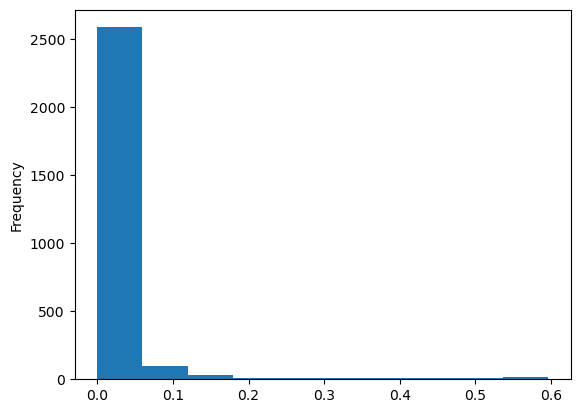

In [244]:
sim[0].plot(kind = "hist")

In [247]:
txt = []
for doc in sim[:4].index:
    with open(f"./data/Texte/{doc}/full.txt", "r", encoding="utf-8") as f:
        texte = f.read()
        print(texte)
        txt.append(texte)
    print("----------------------")

L’eau urbaine et Novatech
Cette interview a été réalisée à l'occasion de la Fête de l'eau organisée par le Grand Lyon les 5 et 6 juin, pour la 5ème conférence internationale sur les stratégies durables en assainissement pluvial : Novatech. C'est l’occasion, pour Jean Villien, d'évoquer la question de l’eau dans la ville et le positionnement de la Mission Ecologie du Grand Lyon vis-à-vis de la Direction de l’eau dont l'un des objectifs est de savoir comment éviter la pollution du milieu naturel par les eaux de ruissellement. 


Novatech est un événement majeur qui permet à de nombreux scientifiques et experts du monde entier de faire le point sur les grands problèmes en matière de gestion des eaux urbaines et d’envisager les différentes réponses, notamment techniques, que l’on peut apporter aujourd’hui. Novatech porte justement sur la gestion des eaux de ruissellement. Lyon est d’ailleurs reconnue internationalement sur la question de l’hydraulique urbaine. On constate, en effet, aujour

### Resumé avec ChatGPT

In [248]:
import openai

with open("api_key", "r", encoding="utf-8") as f:
    openai.api_key = f.read()

prompt = f"""Je cherche à synthétiser au mieux l'information pour dégager les informations des différents textes. Met en avant les principales informations de ces différents textes séparés par ce signe "---" : {"---".join(txt)}"""

openai.organization = "org-mqd2akvmI5TNokavyM3mWXSq"
chat_completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-16k",
    messages = [{"role": "user", 
                 "content": prompt}]
    )
print(chat_completion)

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "La F\u00eate de l'eau et la conf\u00e9rence Novatech se sont tenues \u00e0 Lyon les 5 et 6 juin, o\u00f9 ont \u00e9t\u00e9 abord\u00e9s les enjeux de la gestion des eaux urbaines et de la pollution par les eaux de ruissellement. La Mission Ecologie du Grand Lyon s'int\u00e9resse \u00e0 la question de l'eau dans la ville et travaille en collaboration avec la Direction de l'eau pour \u00e9tudier les aspects patrimoniaux et fonctionnels de l'eau. Novatech met en avant l'expertise de Lyon en mati\u00e8re d'hydraulique urbaine et cherche \u00e0 trouver des solutions techniques pour g\u00e9rer les eaux de ruissellement. Les principales pr\u00e9occupations actuelles concernent la qualit\u00e9 de ces eaux de ruissellement et leur impact sur les cours d'eau naturels. La pollution de l'eau est un enjeu complexe et les diff\u00e9rentes sources de pollution doivent \u00eatre prises en com

In [249]:
for i, carac in enumerate(chat_completion["choices"][0]["message"]["content"]):
    if i%200 == 0:
        print("\n", carac, end = "")
    else:
        print(carac, end="")



 La Fête de l'eau et la conférence Novatech se sont tenues à Lyon les 5 et 6 juin, où ont été abordés les enjeux de la gestion des eaux urbaines et de la pollution par les eaux de ruissellement. La Mis
 sion Ecologie du Grand Lyon s'intéresse à la question de l'eau dans la ville et travaille en collaboration avec la Direction de l'eau pour étudier les aspects patrimoniaux et fonctionnels de l'eau. No
 vatech met en avant l'expertise de Lyon en matière d'hydraulique urbaine et cherche à trouver des solutions techniques pour gérer les eaux de ruissellement. Les principales préoccupations actuelles co
 ncernent la qualité de ces eaux de ruissellement et leur impact sur les cours d'eau naturels. La pollution de l'eau est un enjeu complexe et les différentes sources de pollution doivent être prises en
  compte, notamment les rejets industriels et agricoles. La gestion de l'eau potable est également cruciale, notamment en ce qui concerne l'approvisionnement en eau et le traitement des eaux 

# Pipeline avec LLama2 & HuggingFace